### Задание 1

In [ ]:
# Установка razdel: ее нет в Colab по умолчанию
!pip install razdel

In [ ]:
# Регулярные выражения потребуются для очистки текста
import re

from razdel import sentenize

# Без torch невозможна работа с нейросетями
import torch

# Библиотека transformers нужна для работы с нейросетями-трансформерами,
# которые мы будем использовать для анализа тональности
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Библиотека matplotlib позволит построить графики кривых тональности
from matplotlib import pyplot as plt

# Фильтр Савицкого-Голея понадобится нам для обработки результатов,
# которая будет описана позже
from scipy.signal import savgol_filter

In [ ]:
# Прочитаем текст из целевого файла.
# Не забудьте загрузить его, используя вкладку "Файлы" слева сбоку

import requests
url = 'https://dn720006.ca.archive.org/0/items/1978_20230127/%D0%91%D0%BE%D1%87%D0%B0%D1%80%D0%BE%D0%B2%20%D0%A1.%D0%93.%20-%20%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%20%D0%9B.%20%D0%A2%D0%BE%D0%BB%D1%81%D1%82%D0%BE%D0%B3%D0%BE%20%E2%80%9E%D0%92%D0%BE%D0%B9%D0%BD%D0%B0%20%D0%B8%20%D0%BC%D0%B8%D1%80%E2%80%9C%20%281978%29_djvu.txt'
text = requests.get(url).text

In [ ]:
text
# это очерк Бочарова

"Роман „Л.Голетого \n«ВОЙНА И МИР› \n\n\nОчерк С. Бочарова \n«Война и мир» Л. Тол- \nстого» поможет читателю \nпонять главных героев \n\n\nромана, проникнуть в их \nдуховный мир. Автор \nрассказывает о великой \nэпохе 18412 года, об исто- \nрическом значении этого \nвсенародного испытания \nдля жизни страны. Он \nпознакомит читателя с \nтворческим методом \nЛ. Толстого. \n\n\n‚ ИСТОРИКО* \nЛИТЕРАТУРНАЯ \nБИБЛИОТЕКА \n\n\n( БОЧАРОВ \n\n\nРоман „Л.Толстого \n«ВОЙНА И МИР› \n\n\nИздание третье \n\n\nя \n\n\n«ХУДОЖЕСТВЕННАЯ ЛИТЕРАТУРА» \n\n\n8Р1 \n586 \n\n\nОформление художника \nМ. ШЛОСБЕРГА \n\n\nБочаров С. Г. \n\n\n586 «Война и мир» Л. Н. Толстого. Изд. 3-е. М.., \n«Худож. лит.», 1978. \n\n\n103 с. \n\n\nВ книге о величайшем произведении Толстого — романе \n«Война и мир» автор стремится помочь читателю проникнуть \nв духовный мир героев этого произведения, рассказать об исто- \nрическом значении великой эпохи 1812 года, \n\n\n70202—139 8Р1 \n——___ 266-78 \n028 (01) —78 \n\n\nПамяти \nНа

In [ ]:
def clean_text(text: str) -> str:
    # Заменяем переносы строк на пробелы, убираем лишние пробелы
    cleaned_text = text.replace('\n', ' ').replace('- ', '')
    return cleaned_text

In [ ]:
cleaned_text = clean_text(text)

In [ ]:
cleaned_text

"Роман „Л.Голетого  «ВОЙНА И МИР›    Очерк С. Бочарова  «Война и мир» Л. Тол стого» поможет читателю  понять главных героев    романа, проникнуть в их  духовный мир. Автор  рассказывает о великой  эпохе 18412 года, об исто рическом значении этого  всенародного испытания  для жизни страны. Он  познакомит читателя с  творческим методом  Л. Толстого.    ‚ ИСТОРИКО*  ЛИТЕРАТУРНАЯ  БИБЛИОТЕКА    ( БОЧАРОВ    Роман „Л.Толстого  «ВОЙНА И МИР›    Издание третье    я    «ХУДОЖЕСТВЕННАЯ ЛИТЕРАТУРА»    8Р1  586    Оформление художника  М. ШЛОСБЕРГА    Бочаров С. Г.    586 «Война и мир» Л. Н. Толстого. Изд. 3-е. М..,  «Худож. лит.», 1978.    103 с.    В книге о величайшем произведении Толстого — романе  «Война и мир» автор стремится помочь читателю проникнуть  в духовный мир героев этого произведения, рассказать об исто рическом значении великой эпохи 1812 года,    70202—139 8Р1  ——___ 266-78  028 (01) —78    Памяти  Наталии Александровны Вишневской    1    Эту нобольшую книжку, посвященную «Войне

Чтобы провести динамический анализ тональности, нужно разбить текст на атомарные единицы, которые будут подаваться на вход нейросети. Они не должны быть слишком маленькими, так как в этом случае модель перестанет чувствовать контекст и потеряет своё главное преимущество перед словарём. Они не должны быть и слишком большими, так как размерности входного слоя нейросети может не хватить. В случае книг в качестве этих атомарных единиц лучше всего использовать предложения. Предложения достаточно маленькие по размеру, но выражают законченную мысль.

In [ ]:
# Разобьем текст на предложения (используйте функцию sentenize) и загрузим их в список
sentences = [i.text for i in sentenize(cleaned_text)]


In [ ]:
# Загрузим модель с сайта HuggingFace и создадим ее экземпляр.
# Возможно модели нужно будет скачаться в Colab, нужно подождать.
model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

# Сложная функция, которая заставит модель работать
def estimate_sentiment(messages: list) -> list:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            sentiment_out.append(proba.dot([-1, 0, 1]))
    return sentiment_out

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Произведем нейросетевую оценку тональности
sentiments = estimate_sentiment(sentences)

In [ ]:
import seaborn as sns

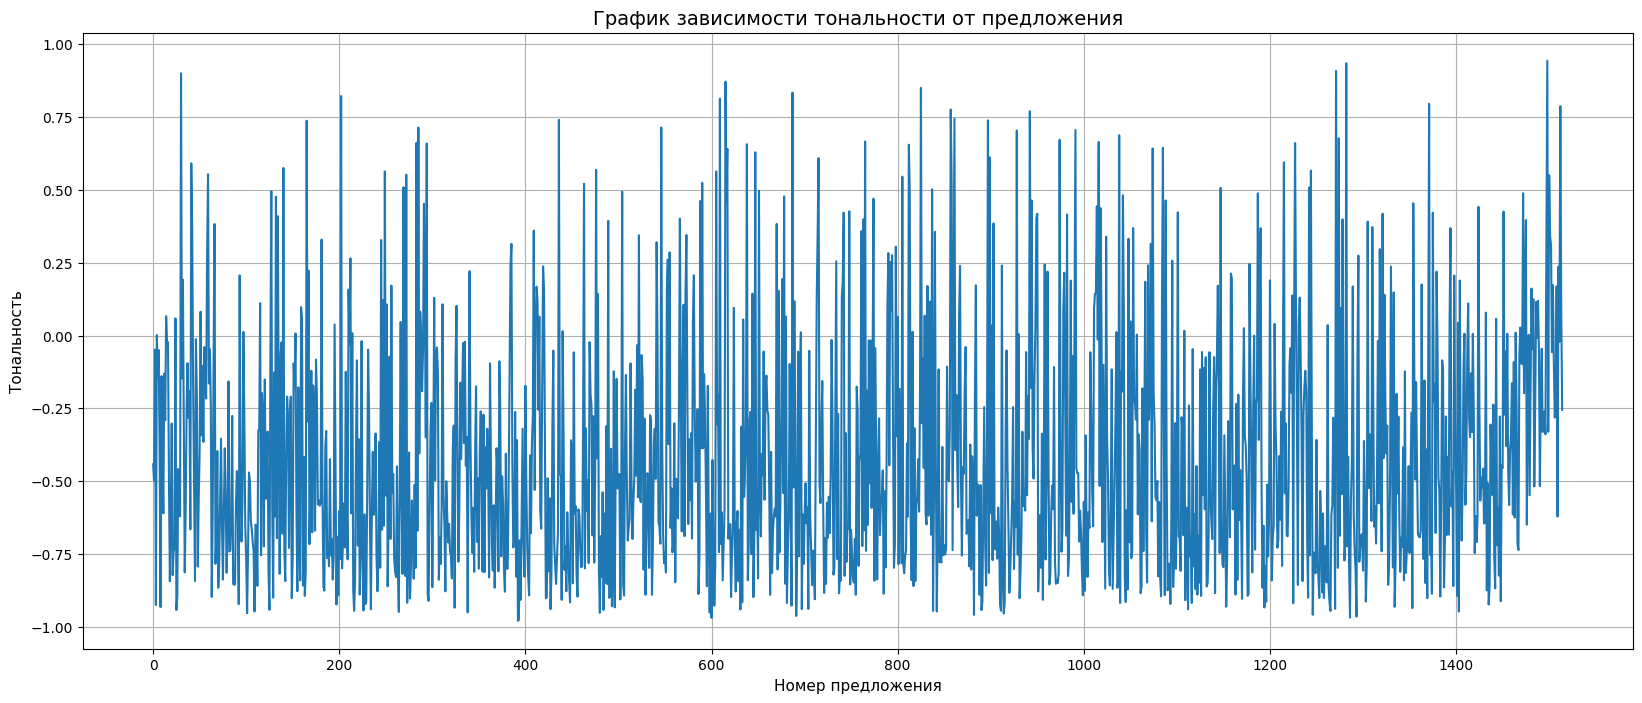

In [ ]:
# Построим график кривой эмоциональной тональности с помощью matplotlib.
# Укажите разрешение графика 150, название оси X — "Номер предложения", оси Y — "Тональность". Добавьте отображение сетки.

plt.figure(1, figsize = (20,8))
ax = sns.lineplot(data=sentiments)
plt.title('График зависимости тональности от предложения', fontsize=14)
plt.ylabel('Тональность', fontsize=11)
plt.xlabel('Номер предложения', fontsize=11)
plt.grid()
plt.show()

Получилось не очень понятно и наглядно. При внимательном рассмотрении можно разглядеть очертания некоторой формы, сильно искажённой скачками и перепадами. Дело в том, что тональность предложений внутри текста может испытывать резкие перепады, а нейросеть может иногда ошибаться. В результате  возникают шумы и некоторая неустойчивость оценки.  


Проблему можно было бы решить, используя в качестве атомарных единиц фрагменты текста большего размера, например, главы. Это не универсальный подход, так как его результаты станут сильно разниться в зависимости от объёмов текста. Решим задачу более изящно и применим фильтры, пришедшие к нам из теории обработки сигналов и призванные отделять полезный сигнал от шумов, которые возникают при его передаче. Выберем фильтр Савицкого-Голея. Этот фильтр уже реализован в Python, мы импортировали его в самом начале.

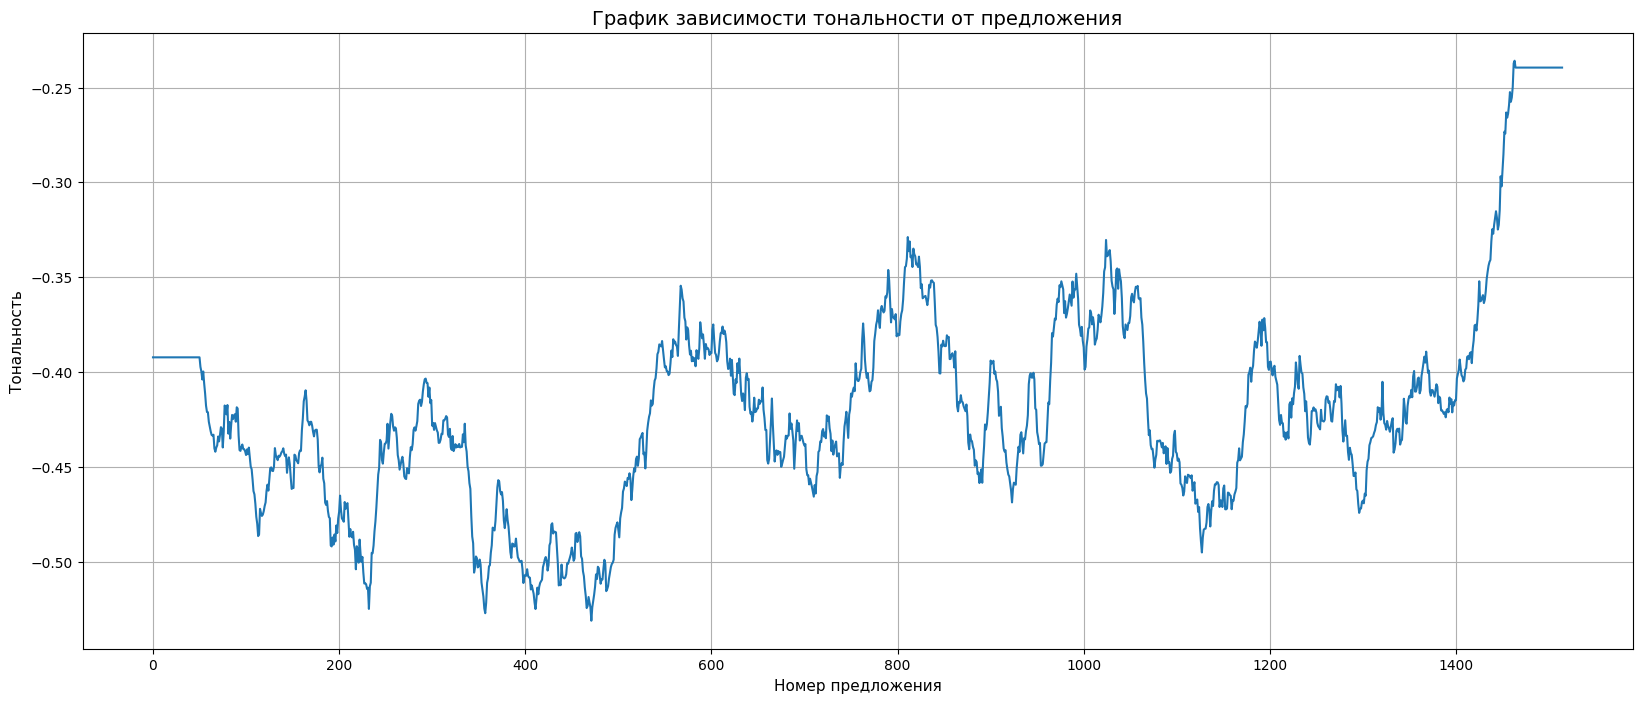

In [ ]:
# Произведем фильтрацию сигнала фильтром Савицкого-Голея
filtered_sentiments = savgol_filter(sentiments, window_length=len(sentiments)//15, polyorder=0)

# Заново постройте график кривой эмоциональной тональности с теми же настройками.

plt.figure(1, figsize = (20,8))
ax = sns.lineplot(data=filtered_sentiments)
plt.title('График зависимости тональности от предложения', fontsize=14)
plt.ylabel('Тональность', fontsize=11)
plt.xlabel('Номер предложения', fontsize=11)
plt.grid()
plt.show()

У фильтра Савицкого-Голея есть параметр ``window_length``, который отвечает за размер окна сглаживания. Выбранное нами по умолчанию значение даёт хорошую картинку, но результаты использования фильтра во многом зависят от выбранного размера окна.

Малые окна сглаживают высокочастотный шум, устраняя мелкие флуктуации, а большие окна сглаживают более крупные колебания и тренды сигнала, оставляя только общие тенденции его поведения. Как найти баланс между размерами окна?

Чтобы получить более гладкую кривую, учитывающую основные тренды исходного графика, можно использовать ансамблевый фильтр. Для этого нужно параллельно обработать зашумлённую кривую несколькими фильтрами Савицкого-Голея с различными размером окна, после чего усреднить результаты всех фильтров. Предполагается, что наиболее значимые изгибы зашумленной кривой тональности окажутся наиболее устойчивыми к сглаживанию большинства фильтров, поэтому будут отражены в окончательном результате.

In [ ]:
# Ансамблевый фильтр
def ensemble_filter(data: list, n_filters=100, window_length_start=10, polyorder=0, **savgol_args) -> list:
    """
    Применяет ансамблевый фильтр к входным данным

    Parameters:
    data (list): входной массив данных
    n_filters (int, optional): число фильтров, участвующих в сглаживании
    """
    window_length_end = window_length_start + n_filters
    step = 1

    result = savgol_filter(data, window_length=window_length_start, polyorder=polyorder)
    for i in range(window_length_start, window_length_end, step):
        result += savgol_filter(data, window_length=i, polyorder=polyorder)

    return result / n_filters
    # Заведите переменную, в которую будете собирать сумму результатов работы фильтров Савицкого-Голея.
    # Вам нужно будет поочерёдно перебирать значения window_length для того, чтобы обработать кривую тональности разными фильтрами.
    # Задайте стартовое и конечное значения window_length, а также шаг изменения, поделённый на n_filters (чтобы значение шага было меньше единицы по итогу).
    # Если шаг получается дробным, округлите его до целого числа вверх.
    # Затем в цикле пройдитесь по всем значениям window_length, обработайте фильтром Савицкого-Голея данные и приплюсуйте все значения в стартовую переменную.
    # В качестве результата функции верните стартовую переменную, разделённую на n_filters.

    # ВАШ КОД ЗДЕСЬ

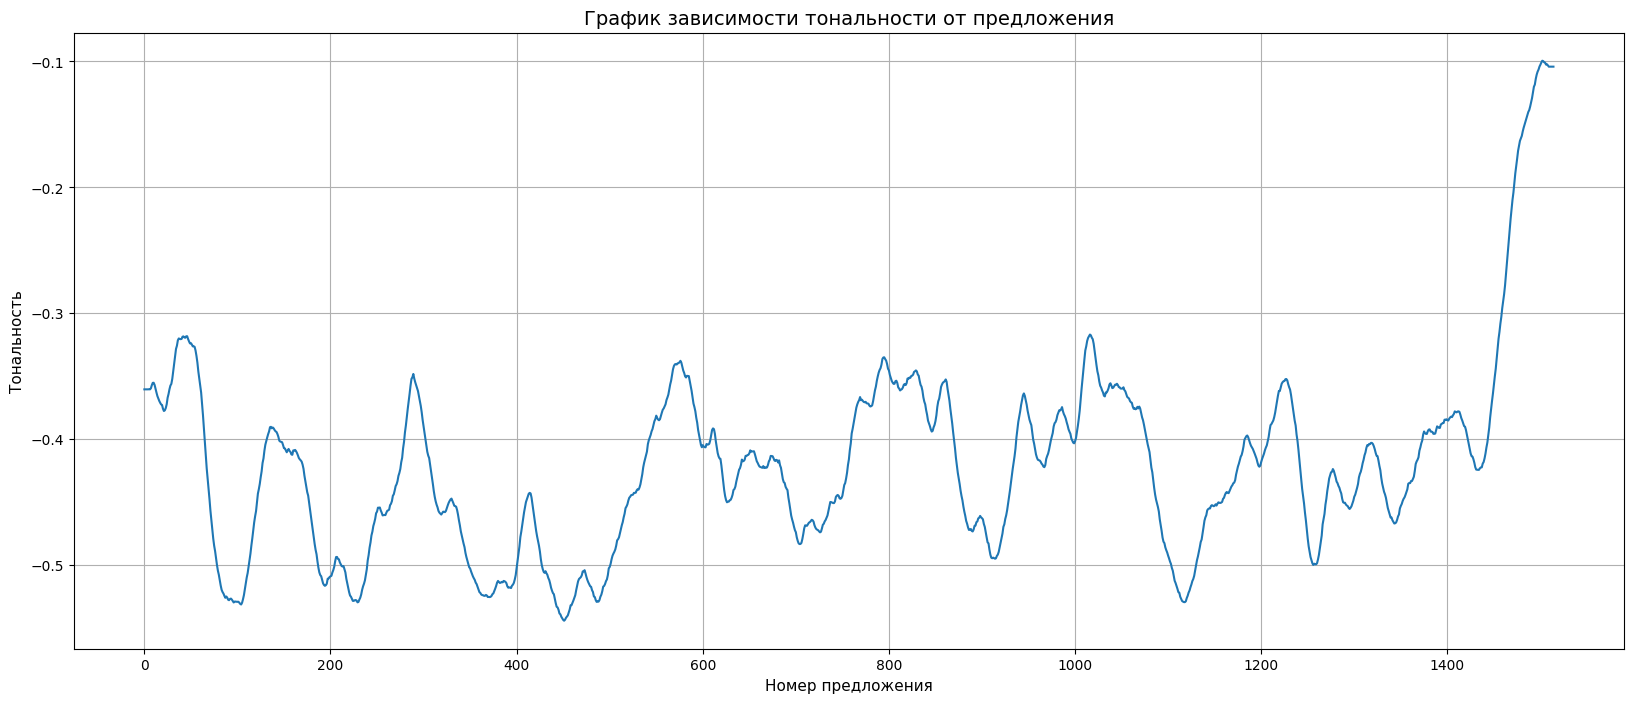

In [ ]:
# Произведем фильтрацию сигнала ансамблевым фильтром

ensemble_filtered = ensemble_filter(sentiments)

# Заново постройте график кривой эмоциональной тональности с теми же настройками.

plt.figure(1, figsize = (20,8))
ax = sns.lineplot(data=ensemble_filtered)
plt.title('График зависимости тональности от предложения', fontsize=14)
plt.ylabel('Тональность', fontsize=11)
plt.xlabel('Номер предложения', fontsize=11)
plt.grid()
plt.show()

### Задание 2

Выберите несколько похожих на ваш взгляд произведений: одного автора, с похожим сюжетом или части одной серии. Проанализируйте их по очереди и отобразите кривые тональности на общем графике. Проанализируйте этот график и опишите ваши выводы. Обратите внимание: произведения должны быть примерно равны по длине либо необходимо пропорционально сжать/растянуть графики.

In [ ]:
pip install tika

  Preparing metadata (setup.py) ... done
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32624 sha256=3ae7599418abafdf023b97a56d67f24f11fab546db32f880f649ddd8e54cc91d
  Stored in directory: /root/.cache/pip/wheels/27/ba/2f/37420d1191bdae5e855d69b8e913673045bfd395cbd78ad697
Successfully built tika


In [ ]:
from tika import parser


texts = []
for i in range(1, 8):
    raw = parser.from_file(f'{i}.pdf')
    texts.append(raw['content'])

In [ ]:
cleaned_texts = [clean_text(text) for text in texts]

In [ ]:
sentences = [[i.text for i in sentenize(text)] for text in cleaned_texts]

In [ ]:
sentiments = [estimate_sentiment(s) for s in sentences]

In [ ]:
ensemble_filtered = [ensemble_filter(s, 100, 70) for s in sentiments]

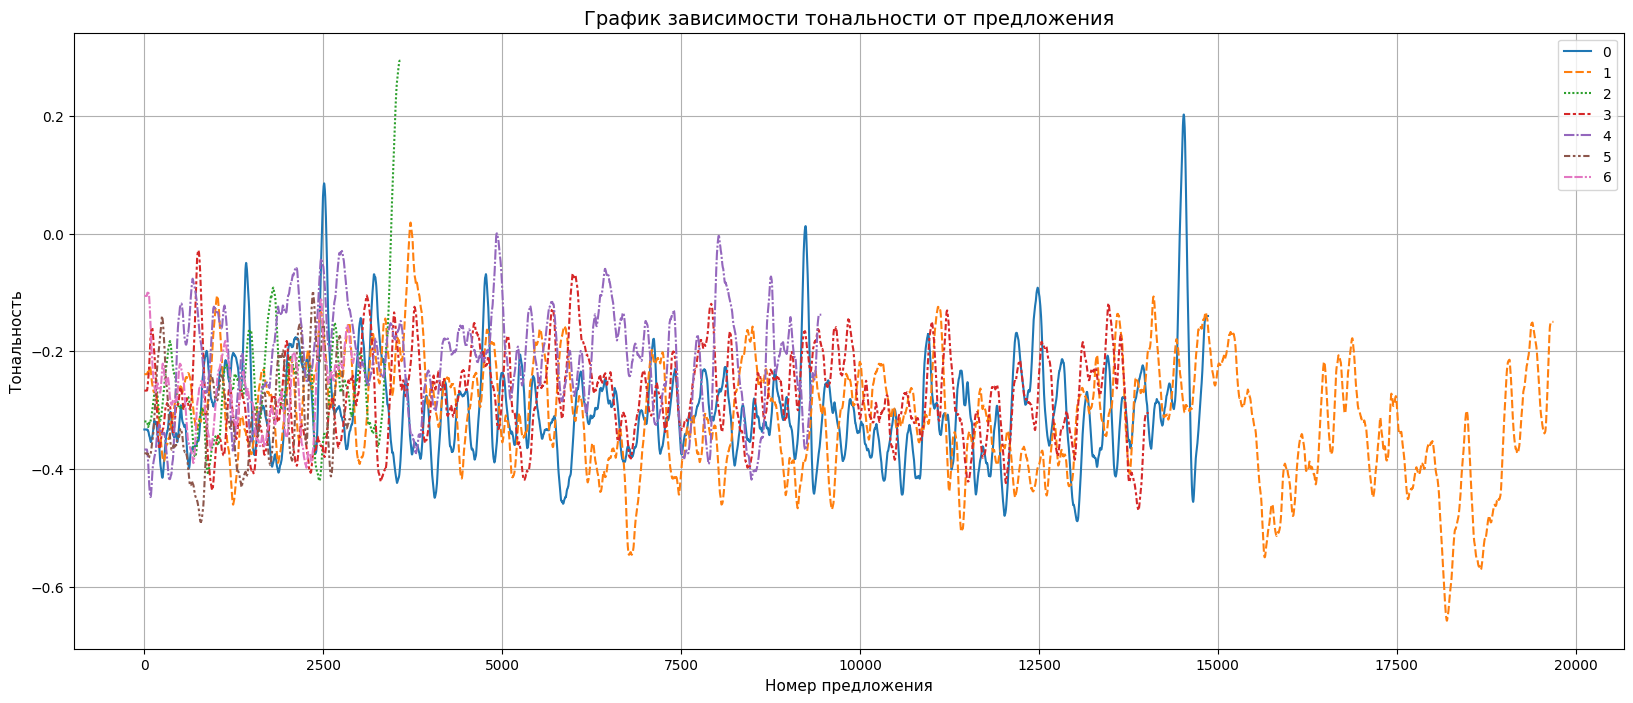

In [ ]:
plt.figure(1, figsize = (20,8))
ax = sns.lineplot(data=ensemble_filtered)
plt.title('График зависимости тональности от предложения', fontsize=14)
plt.ylabel('Тональность', fontsize=11)
plt.xlabel('Номер предложения', fontsize=11)
plt.grid()
plt.show()

Это все тексты Достоевского. Все находятся примерно в одной тональности от -0.4 до -0.1

### Задание 3

Попробуйте использовать другую модель с [HuggingFace](https://huggingface.co/models), выбрав такую, чтобы она была преобучена на русском языке и работала с анализом тональности. Сравните результаты, отличаются ли они?

In [ ]:
model_checkpoint = 'MonoHime/rubert-base-cased-sentiment-new'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

# Сложная функция, которая заставит модель работать
def estimate_sentiment_2(messages: list) -> list:
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            sentiment_out.append(proba.dot([-1, 0, 1]))
    return sentiment_out

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [ ]:
sentiments_2 = [estimate_sentiment_2(s) for s in sentences]